<a href="https://colab.research.google.com/github/Prisze/AAI-590Capstone/blob/main/Capstone_Dataset_Cleanup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import gdown

url = "https://drive.google.com/uc?id=1rWs5F3UO9h1BDnFSFDhLJmDC3F0BvhSM"
output = "dataset.zip"  # change name if needed

gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1rWs5F3UO9h1BDnFSFDhLJmDC3F0BvhSM
From (redirected): https://drive.google.com/uc?id=1rWs5F3UO9h1BDnFSFDhLJmDC3F0BvhSM&confirm=t&uuid=dea24f31-2f17-4f9b-975d-57e2d384a897
To: /content/dataset.zip
100%|██████████| 1.81G/1.81G [00:25<00:00, 72.2MB/s]


'dataset.zip'

In [ ]:
!unzip dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/Validation/Real/real_5499.jpg  
  inflating: Dataset/Validation/Real/real_55.jpg  
  inflating: Dataset/Validation/Real/real_550.jpg  
  inflating: Dataset/Validation/Real/real_5500.jpg  
  inflating: Dataset/Validation/Real/real_5501.jpg  
  inflating: Dataset/Validation/Real/real_5502.jpg  
  inflating: Dataset/Validation/Real/real_5503.jpg  
  inflating: Dataset/Validation/Real/real_5504.jpg  
  inflating: Dataset/Validation/Real/real_5505.jpg  
  inflating: Dataset/Validation/Real/real_5506.jpg  
  inflating: Dataset/Validation/Real/real_5507.jpg  
  inflating: Dataset/Validation/Real/real_5508.jpg  
  inflating: Dataset/Validation/Real/real_5509.jpg  
  inflating: Dataset/Validation/Real/real_551.jpg  
  inflating: Dataset/Validation/Real/real_5510.jpg  
  inflating: Dataset/Validation/Real/real_5511.jpg  
  inflating: Dataset/Validation/Real/real_5512.jpg  
  inflating: Dataset/Validation/Real/real_5513.jpg  

Raw counts by split/label:
     split label  count
      Test  Fake   5492
      Test  Real   5413
     Train  Fake  70001
     Train  Real  70001
Validation  Fake  19641
Validation  Real  19787

Pivot table:
label              Fake   Real   TOTAL
split                                 
Test               5492   5413   10905
Train             70001  70001  140002
Validation        19641  19787   39428
ALL_SPLITS_TOTAL  95134  95201  190335


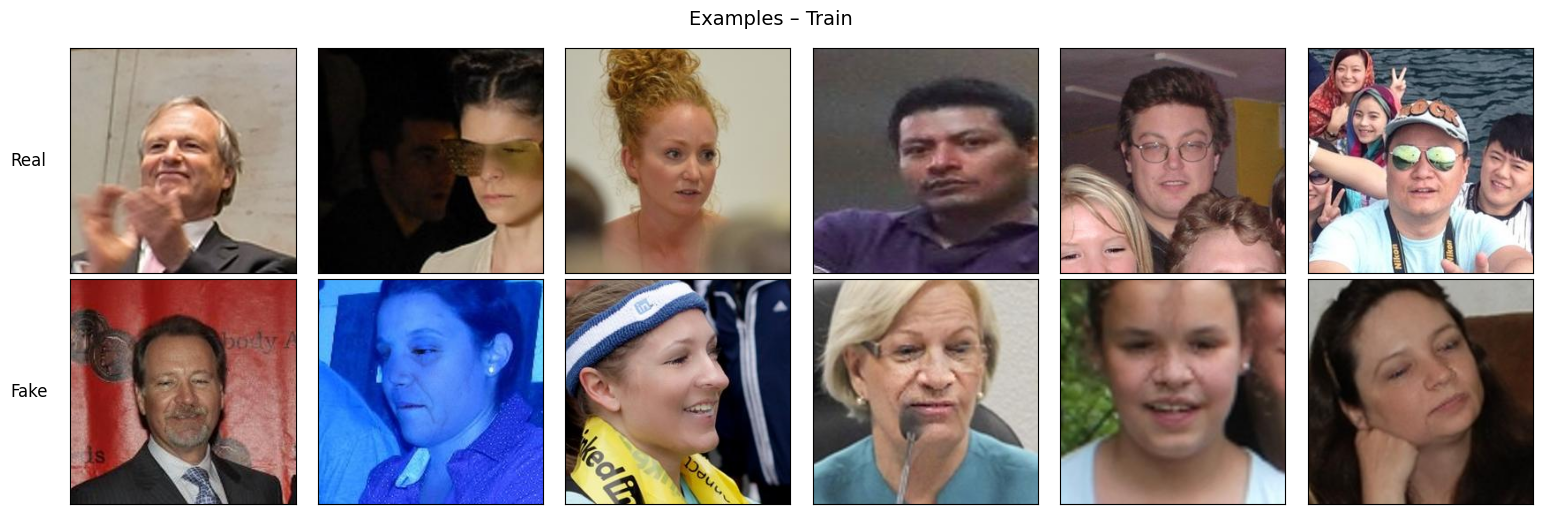

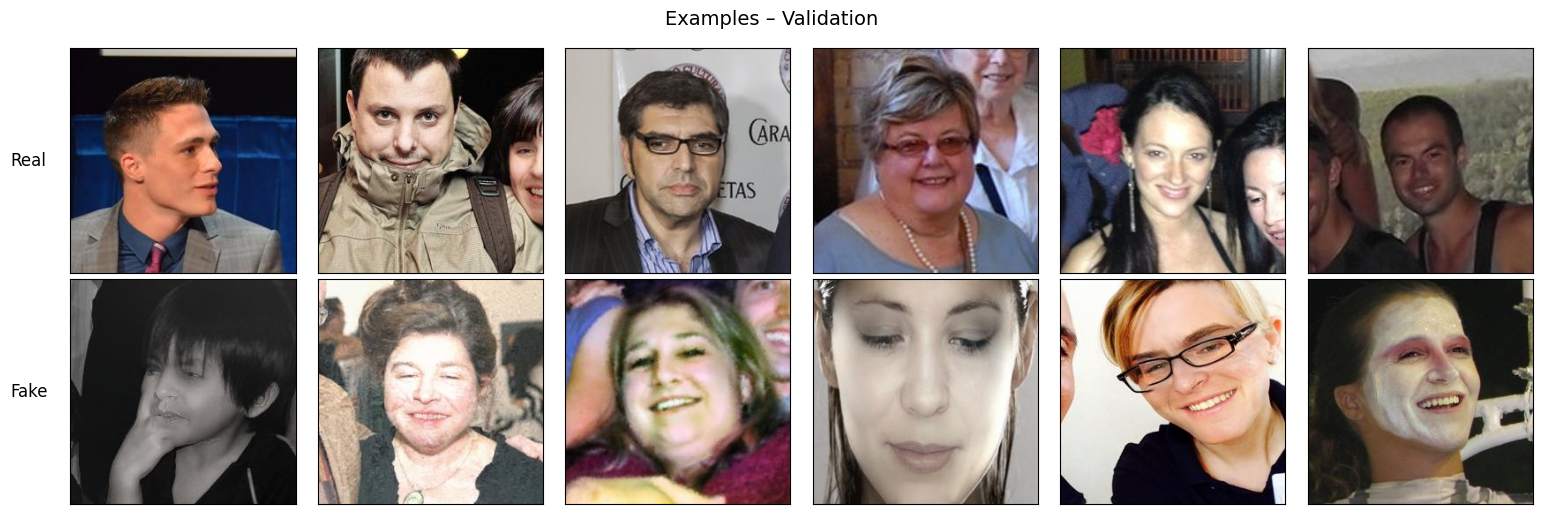

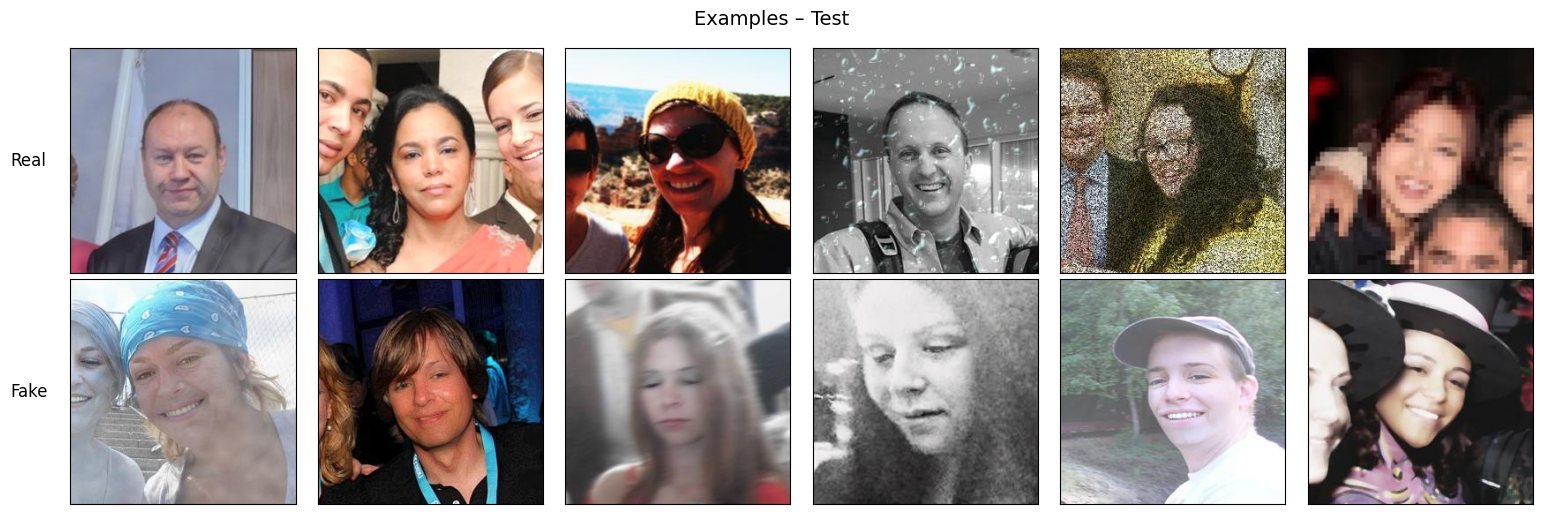

In [ ]:
from pathlib import Path
import random
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

# --- Config ---
DATASET_ROOT = Path("Dataset")  # <- change if your root folder has a different name
VALID_EXT = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".gif"}  # tweak if needed
RANDOM_SEED = 42

def iter_images(dirpath: Path):
    """Yield image file Paths under dirpath (recursive), filtered by VALID_EXT."""
    for p in dirpath.rglob("*"):
        if p.is_file() and p.suffix.lower() in VALID_EXT:
            yield p

def collect_counts(dataset_root: Path) -> pd.DataFrame:
    """
    Return a DataFrame with columns: split, label, count
    Works with any subfolders under dataset_root as splits, and any subfolders
    inside each split as class labels (e.g., Real/Fake).
    """
    rows = []
    for split_dir in sorted([d for d in dataset_root.iterdir() if d.is_dir()]):
        split_name = split_dir.name
        class_dirs = sorted([d for d in split_dir.iterdir() if d.is_dir()])
        if not class_dirs:
            # If images are directly under the split folder (no class subfolders)
            count = sum(1 for _ in iter_images(split_dir))
            rows.append({"split": split_name, "label": "(unlabeled)", "count": count})
            continue

        for cdir in class_dirs:
            label = cdir.name
            count = sum(1 for _ in iter_images(cdir))
            rows.append({"split": split_name, "label": label, "count": count})

    df = pd.DataFrame(rows).sort_values(["split", "label"]).reset_index(drop=True)
    return df

def pivot_counts(df: pd.DataFrame) -> pd.DataFrame:
    """Pivot counts into a table with splits as rows and labels as columns."""
    piv = df.pivot_table(index="split", columns="label", values="count", fill_value=0, aggfunc="sum")
    piv["TOTAL"] = piv.sum(axis=1)
    piv.loc["ALL_SPLITS_TOTAL"] = piv.sum(axis=0)
    return piv.astype(int)

def show_matrix(dataset_root: Path, split: str, labels=None, ncols=6, figsize_per_cell=2.6):
    """
    Show a matrix (grid) of example images for a given split.
    One row per label (e.g., Real/Fake), ncols images per row (if available).
    """
    split_dir = dataset_root / split
    if not split_dir.exists():
        print(f"[warn] Split folder not found: {split_dir}")
        return

    # Auto-detect labels if not provided (all subfolders under split)
    if labels is None:
        labels = sorted([d.name for d in split_dir.iterdir() if d.is_dir()])
        if not labels:
            print(f"[warn] No class subfolders found under {split_dir}")
            return

    # Collect images for each label
    label_to_imgs = {}
    for lbl in labels:
        cdir = split_dir / lbl
        if not cdir.exists():
            print(f"[warn] Missing class folder: {cdir}")
            label_to_imgs[lbl] = []
        else:
            label_to_imgs[lbl] = list(iter_images(cdir))

    # Determine how many columns we can actually show (min across classes, up to ncols)
    available_per_label = [len(v) for v in label_to_imgs.values()]
    if any(cnt == 0 for cnt in available_per_label):
        empties = [lbl for lbl, cnt in label_to_imgs.items() if cnt == 0]
        print(f"[warn] No images for {empties} in split '{split}'. Skipping grid.")
        return
    cols = min(ncols, *available_per_label)

    # Prepare figure
    rows = len(labels)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * figsize_per_cell, rows * figsize_per_cell))
    if rows == 1:
        axes = [axes]  # make iterable for single-row case

    rng = random.Random(RANDOM_SEED)
    for r, lbl in enumerate(labels):
        imgs = label_to_imgs[lbl]
        # Pick random unique samples
        picks = rng.sample(imgs, k=cols) if len(imgs) >= cols else imgs
        for c, img_path in enumerate(picks):
            ax = axes[r][c] if rows > 1 else axes[c]
            try:
                img = Image.open(img_path)
                ax.imshow(img)
            except Exception as e:
                ax.text(0.5, 0.5, f"Error\n{img_path.name}", ha="center", va="center")
            ax.set_xticks([]); ax.set_yticks([])
            if c == 0:
                ax.set_ylabel(lbl, rotation=0, labelpad=30, fontsize=12, va="center")
    fig.suptitle(f"Examples – {split}", fontsize=14)
    plt.tight_layout()
    plt.show()

# ---- Run EDA ----
df_counts = collect_counts(DATASET_ROOT)
print("Raw counts by split/label:")
print(df_counts.to_string(index=False))

print("\nPivot table:")
print(pivot_counts(df_counts))

# Show example grids; will auto-detect labels (expects 'Real' and 'Fake')
detected_splits = [d.name for d in DATASET_ROOT.iterdir() if d.is_dir()]
# Keep a friendly order if present
preferred_order = ["Train", "Validation", "Val", "Test"]
ordered_splits = [s for s in preferred_order if s in detected_splits] + [s for s in detected_splits if s not in preferred_order]

for split in ordered_splits:
    show_matrix(DATASET_ROOT, split=split, labels=["Real", "Fake"], ncols=6)


In [ ]:
!pip install deepface

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.3/128.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 54.4 MB/s eta 0:00:00


In [ ]:
!pip install pyiqa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 41.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 17.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.2/276.2 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 92.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 333.2/333.2 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.4/299.4 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Train split (before sampling):
  Real: 70001 images
  Fake: 70001 images

Using up to 5000 images per category (if available):
  Real used: 5000 images
  Fake used: 5000 images

=== Computing per-pixel distributions ===


Train Fake (per-pixel): 100%|██████████| 5000/5000 [00:53<00:00, 93.63img/s]


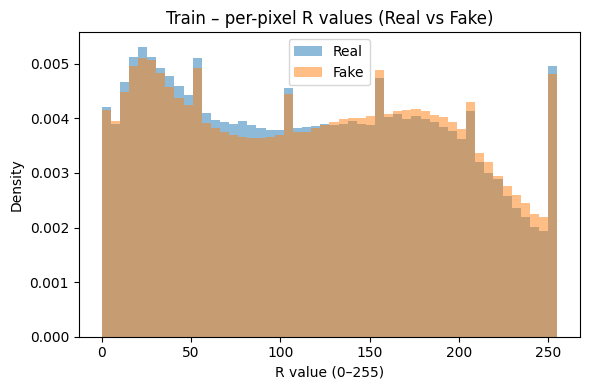

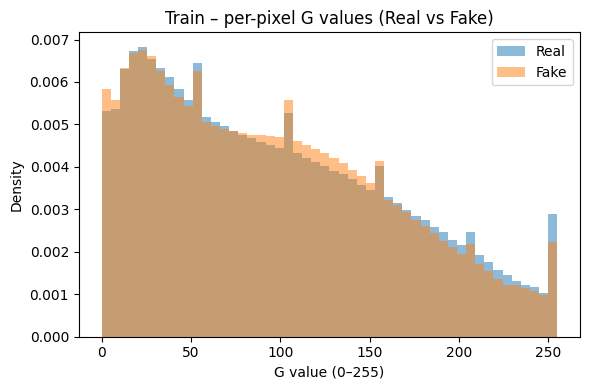

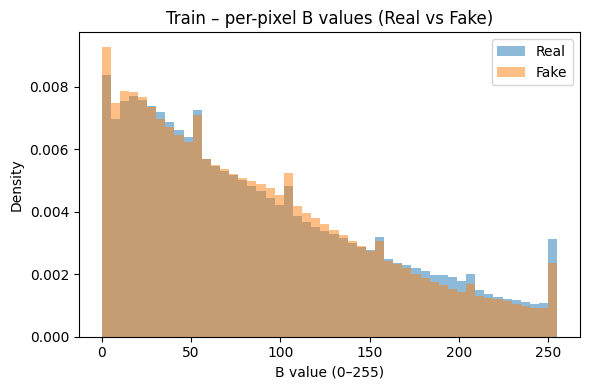

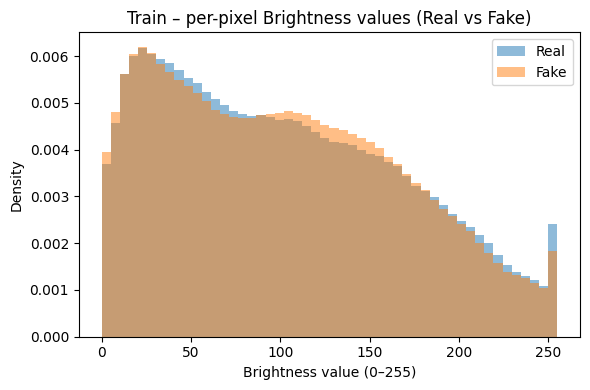

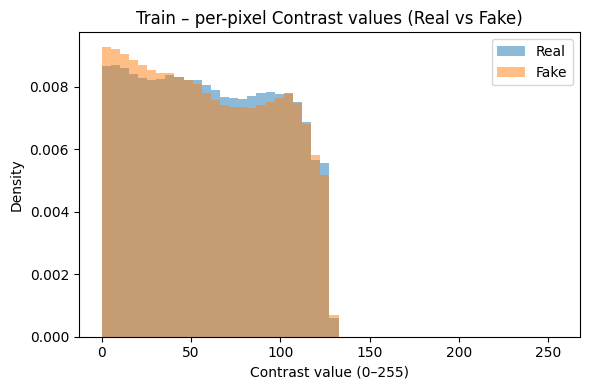


=== Computing image-level statistics (mean/median/std) ===


Train Fake (image-level stats): 100%|██████████| 5000/5000 [00:34<00:00, 143.00img/s]



Plotting distributions of MEAN per image...


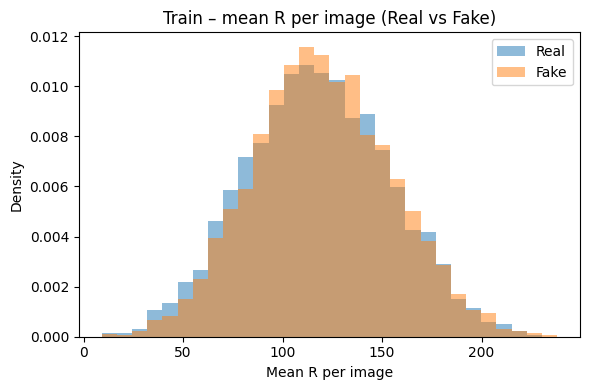

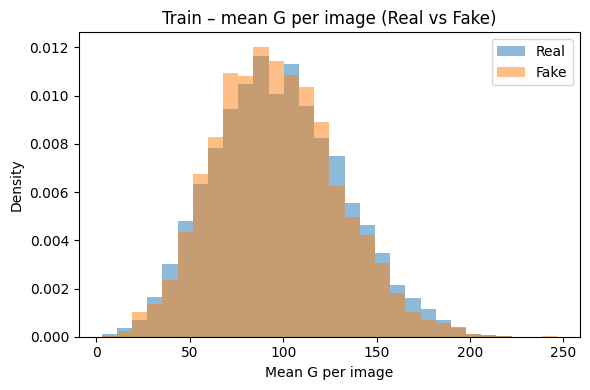

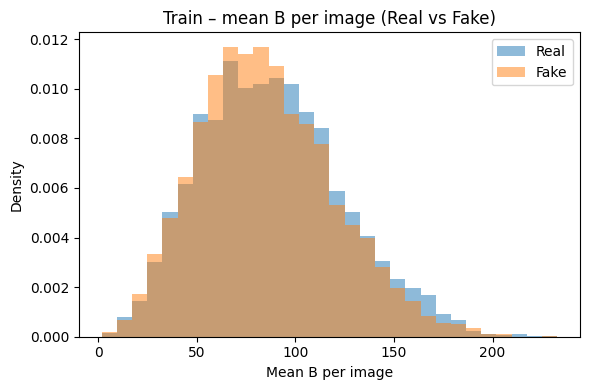

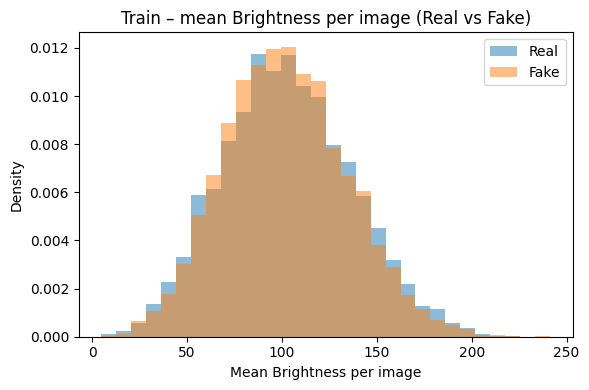

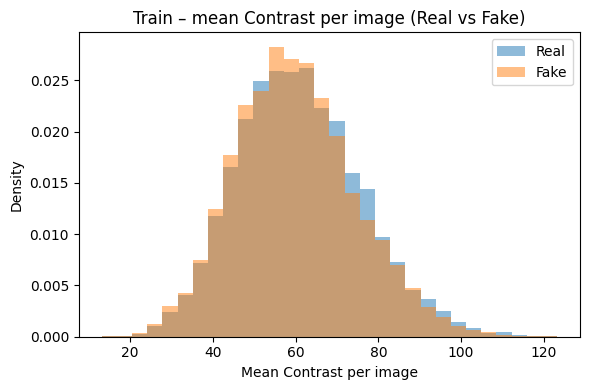


Plotting distributions of MEDIAN per image...


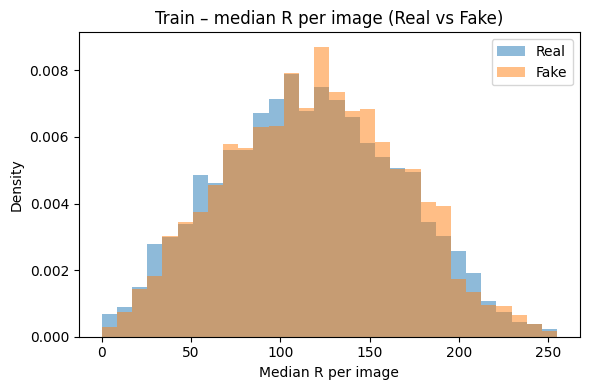

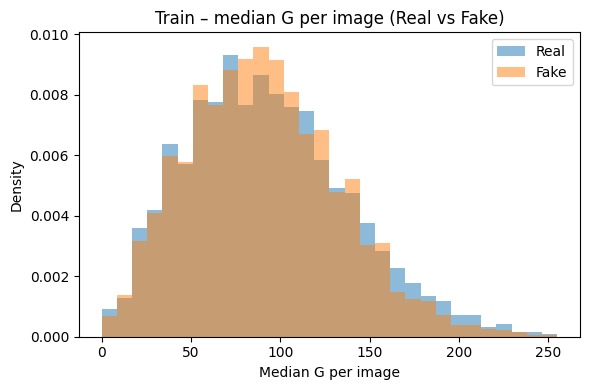

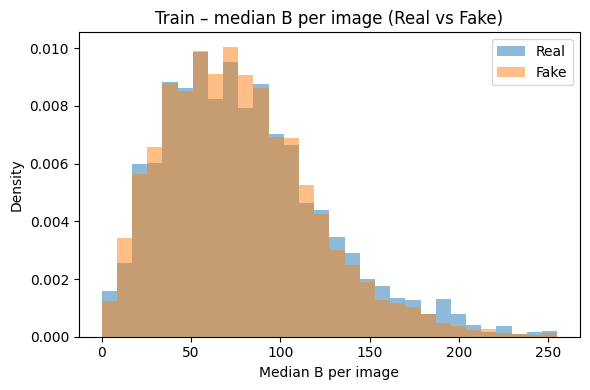

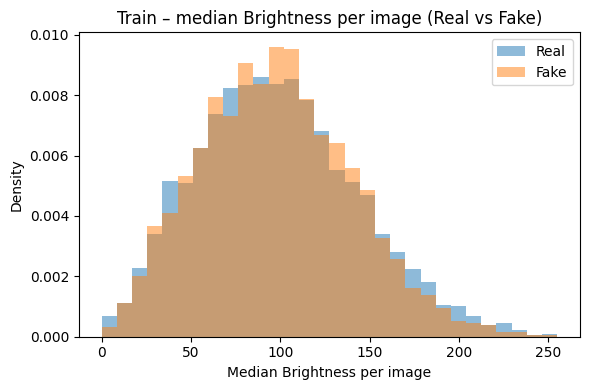

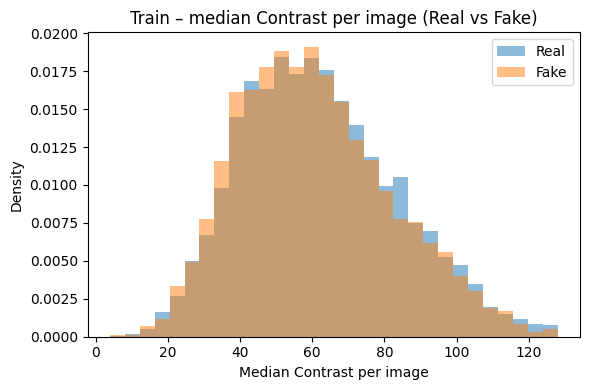


Plotting distributions of STD per image...


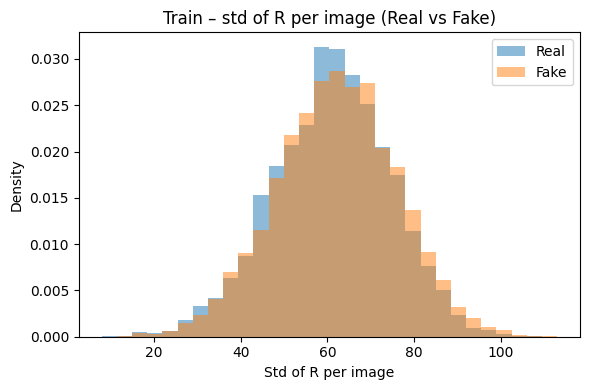

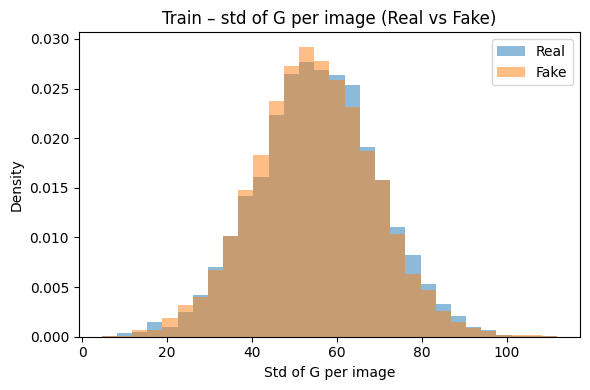

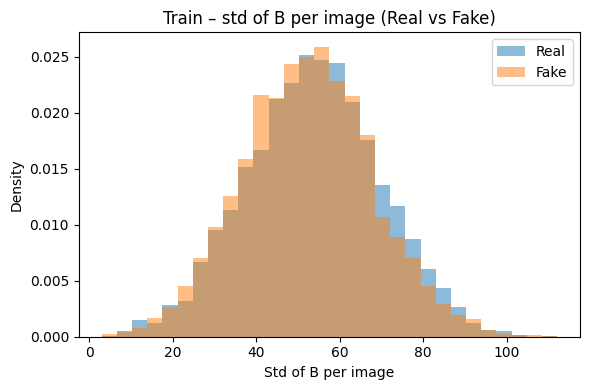

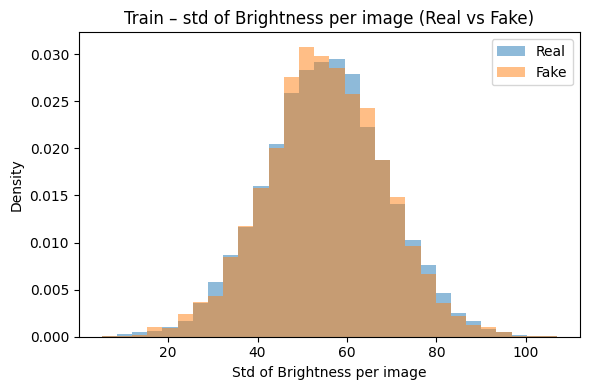

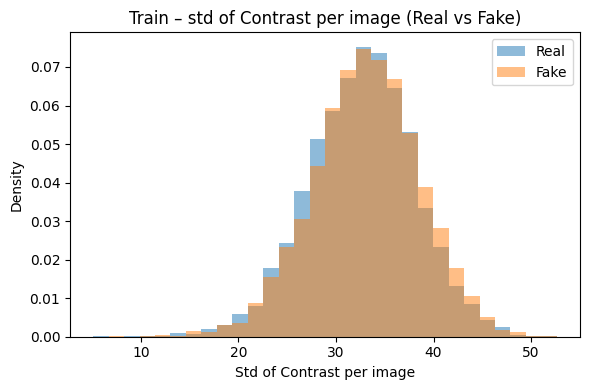

In [ ]:
from pathlib import Path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

# -------------------
# CONFIG
# -------------------
DATASET_ROOT = Path("Dataset")   # root folder
SPLIT = "Train"                  # choose one: "Train", "Test", "Validation", etc.
VALID_EXT = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".gif"}

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Which tests to run?
RUN_PER_PIXEL_HISTS = True       # 5 histograms: per-pixel distributions
RUN_MEAN_HISTS = True            # 5 histograms: mean per image
RUN_MEDIAN_HISTS = True          # 5 histograms: median per image
RUN_STD_HISTS = True             # 5 histograms: std per image

# Max number of images per category (Real/Fake). None = use all.
MAX_IMAGES_PER_CATEGORY = 5000    # e.g. 200; set to None to use every image

# Max sampled pixels per image for per-pixel histograms (to save memory/time)
MAX_PIXELS_PER_IMAGE = 20000

METRIC_NAMES = ["R", "G", "B", "Brightness", "Contrast"]


# -------------------
# HELPERS
# -------------------
def iter_images(dirpath: Path):
    """Yield image files under dirpath (non-recursive) filtered by VALID_EXT."""
    if not dirpath.exists():
        return
    for p in dirpath.iterdir():
        if p.is_file() and p.suffix.lower() in VALID_EXT:
            yield p


def load_image_array(path: Path) -> np.ndarray:
    """
    Load an image as RGB and return a float32 array in [0, 255].
    Shape: (H, W, 3)
    """
    img = Image.open(path).convert("RGB")
    return np.asarray(img, dtype=np.float32)


def compute_per_pixel_metrics(img_arr: np.ndarray):
    """
    Given an RGB image array in [0,255], compute:
      - R, G, B channels
      - Brightness: standard luma 0.299 R + 0.587 G + 0.114 B
      - Contrast: abs(Brightness - 128)  (distance from mid-gray)
    Returns a dict of 2D arrays (H, W) for each metric.
    """
    r = img_arr[..., 0]
    g = img_arr[..., 1]
    b = img_arr[..., 2]

    brightness = 0.299 * r + 0.587 * g + 0.114 * b
    contrast = np.abs(brightness - 128.0)

    return {
        "R": r,
        "G": g,
        "B": b,
        "Brightness": brightness,
        "Contrast": contrast,
    }


def sample_image_paths(image_paths, max_images):
    """
    Randomly sample up to max_images from image_paths.
    If max_images is None or len(image_paths) <= max_images, return as-is.
    """
    image_paths = list(image_paths)
    if max_images is None or len(image_paths) <= max_images:
        return image_paths
    idx = np.random.permutation(len(image_paths))[:max_images]
    return [image_paths[i] for i in idx]


def gather_pixel_distributions(image_paths, max_pixels_per_image=20000, desc="Processing images"):
    """
    For a list of image paths, return a dict:
       metric_name -> 1D array of sampled pixel values across all images.
    Uses tqdm to show progress.
    """
    metric_pixels = {k: [] for k in METRIC_NAMES}

    for path in tqdm(image_paths, desc=desc, unit="img"):
        img_arr = load_image_array(path)
        metric_maps = compute_per_pixel_metrics(img_arr)

        for name in METRIC_NAMES:
            vals = metric_maps[name].reshape(-1)
            if max_pixels_per_image is not None and vals.size > max_pixels_per_image:
                idx = np.random.choice(vals.size, size=max_pixels_per_image, replace=False)
                vals = vals[idx]
            metric_pixels[name].append(vals)

    # Concatenate into single arrays
    for name in METRIC_NAMES:
        if metric_pixels[name]:
            metric_pixels[name] = np.concatenate(metric_pixels[name])
        else:
            metric_pixels[name] = np.array([])

    return metric_pixels


def gather_image_level_stats(image_paths, desc="Computing image-level stats"):
    """
    For each image, compute mean, median and std of each metric over all pixels.
    Uses tqdm to show progress.

    Returns:
      stats["mean"][metric]   -> 1D array, one value per image
      stats["median"][metric] -> 1D array, one value per image
      stats["std"][metric]    -> 1D array, one value per image
    """
    stats = {
        "mean": {k: [] for k in METRIC_NAMES},
        "median": {k: [] for k in METRIC_NAMES},
        "std": {k: [] for k in METRIC_NAMES},
    }

    for path in tqdm(image_paths, desc=desc, unit="img"):
        img_arr = load_image_array(path)
        metric_maps = compute_per_pixel_metrics(img_arr)

        for name in METRIC_NAMES:
            v = metric_maps[name].reshape(-1)
            stats["mean"][name].append(float(v.mean()))
            stats["median"][name].append(float(np.median(v)))
            stats["std"][name].append(float(v.std()))

    # Convert lists to numpy arrays
    for stat_name in stats:
        for metric in METRIC_NAMES:
            stats[stat_name][metric] = np.array(stats[stat_name][metric])

    return stats


def plot_hist_comparison(real_vals,
                         fake_vals,
                         title,
                         xlabel,
                         bins=50,
                         value_range=None):
    """
    Plot two superposed histograms: Real vs Fake (semi-transparent).
    """
    real_vals = np.asarray(real_vals)
    fake_vals = np.asarray(fake_vals)

    if real_vals.size == 0 or fake_vals.size == 0:
        print(f"[warn] Not enough data to plot: {title}")
        return

    if value_range is None:
        vmin = min(real_vals.min(), fake_vals.min())
        vmax = max(real_vals.max(), fake_vals.max())
        value_range = (vmin, vmax)

    plt.figure(figsize=(6, 4))
    plt.hist(real_vals,
             bins=bins,
             range=value_range,
             alpha=0.5,           # semi-transparent
             density=True,
             label="Real")
    plt.hist(fake_vals,
             bins=bins,
             range=value_range,
             alpha=0.5,           # semi-transparent
             density=True,
             label="Fake")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()



# 0) Collect image paths for the chosen split
split_dir = DATASET_ROOT / SPLIT
real_dir = split_dir / "Real"
fake_dir = split_dir / "Fake"

real_paths_all = list(iter_images(real_dir))
fake_paths_all = list(iter_images(fake_dir))

print(f"{SPLIT} split (before sampling):")
print(f"  Real: {len(real_paths_all)} images")
print(f"  Fake: {len(fake_paths_all)} images")

# Apply max-images-per-category sampling
real_paths = sample_image_paths(real_paths_all, MAX_IMAGES_PER_CATEGORY)
fake_paths = sample_image_paths(fake_paths_all, MAX_IMAGES_PER_CATEGORY)

print(f"\nUsing up to {MAX_IMAGES_PER_CATEGORY} images per category (if available):")
print(f"  Real used: {len(real_paths)} images")
print(f"  Fake used: {len(fake_paths)} images")

if not real_paths or not fake_paths:
    print("ERROR: One of the classes has no images. Check folder names and paths.")
else:
    # 1) PER-PIXEL DISTRIBUTIONS (5 plots)
    if RUN_PER_PIXEL_HISTS:
        print("\n=== Computing per-pixel distributions ===")
        pixel_real = gather_pixel_distributions(
            real_paths,
            max_pixels_per_image=MAX_PIXELS_PER_IMAGE,
            desc=f"{SPLIT} Real (per-pixel)"
        )
        pixel_fake = gather_pixel_distributions(
            fake_paths,
            max_pixels_per_image=MAX_PIXELS_PER_IMAGE,
            desc=f"{SPLIT} Fake (per-pixel)"
        )

        for metric in METRIC_NAMES:
            plot_hist_comparison(
                pixel_real[metric],
                pixel_fake[metric],
                title=f"{SPLIT} – per-pixel {metric} values (Real vs Fake)",
                xlabel=f"{metric} value (0–255)",
                bins=255,
                value_range=(0, 255),  # all metrics are roughly in this range
            )

    # 2–4) IMAGE-LEVEL STATS: MEAN / MEDIAN / STD
    need_image_stats = RUN_MEAN_HISTS or RUN_MEDIAN_HISTS or RUN_STD_HISTS

    if need_image_stats:
        print("\n=== Computing image-level statistics (mean/median/std) ===")
        img_stats_real = gather_image_level_stats(
            real_paths,
            desc=f"{SPLIT} Real (image-level stats)"
        )
        img_stats_fake = gather_image_level_stats(
            fake_paths,
            desc=f"{SPLIT} Fake (image-level stats)"
        )

        # MEAN
        if RUN_MEAN_HISTS:
            print("\nPlotting distributions of MEAN per image...")
            for metric in METRIC_NAMES:
                plot_hist_comparison(
                    img_stats_real["mean"][metric],
                    img_stats_fake["mean"][metric],
                    title=f"{SPLIT} – mean {metric} per image (Real vs Fake)",
                    xlabel=f"Mean {metric} per image",
                    bins=255,
                    value_range=None,  # auto-range based on data
                )

        # MEDIAN
        if RUN_MEDIAN_HISTS:
            print("\nPlotting distributions of MEDIAN per image...")
            for metric in METRIC_NAMES:
                plot_hist_comparison(
                    img_stats_real["median"][metric],
                    img_stats_fake["median"][metric],
                    title=f"{SPLIT} – median {metric} per image (Real vs Fake)",
                    xlabel=f"Median {metric} per image",
                    bins=255,
                    value_range=None,
                )

        # STD
        if RUN_STD_HISTS:
            print("\nPlotting distributions of STD per image...")
            for metric in METRIC_NAMES:
                plot_hist_comparison(
                    img_stats_real["std"][metric],
                    img_stats_fake["std"][metric],
                    title=f"{SPLIT} – std of {metric} per image (Real vs Fake)",
                    xlabel=f"Std of {metric} per image",
                    bins=255,
                    value_range=None,
                )


Real: using 1000 images
Fake: using 1000 images

Candidate metrics from pyiqa:
['musiq', 'nima', 'niqe', 'nrqm', 'paq2piq', 'pi', 'piqe', 'sfid', 'topiq_iaa', 'topiq_iaa_res50', 'topiq_nr', 'tres', 'tres-flive', 'unique', 'uranker', 'wadiqam_nr']

=== Metric: musiq ===
Loading pretrained model MUSIQ from /root/.cache/torch/hub/pyiqa/musiq_koniq_ckpt-e95806b9.pth


musiq - Real:   0%|          | 0/1000 [00:00<?, ?it/s]

musiq - Fake:   0%|          | 0/1000 [00:00<?, ?it/s]

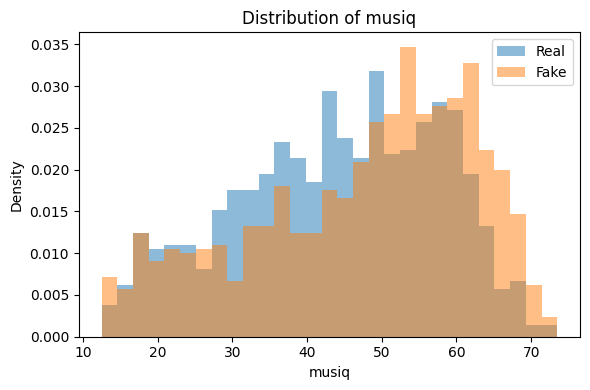


=== Metric: nima ===
Loading pretrained model NIMA from /root/.cache/torch/hub/pyiqa/NIMA_InceptionV2_ava-b0c77c00.pth


nima - Real:   0%|          | 0/1000 [00:00<?, ?it/s]

nima - Fake:   0%|          | 0/1000 [00:00<?, ?it/s]

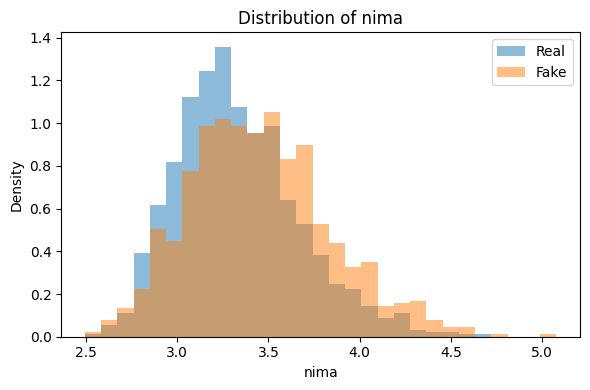


=== Metric: niqe ===


niqe - Real:   0%|          | 0/1000 [00:00<?, ?it/s]

niqe - Fake:   0%|          | 0/1000 [00:00<?, ?it/s]

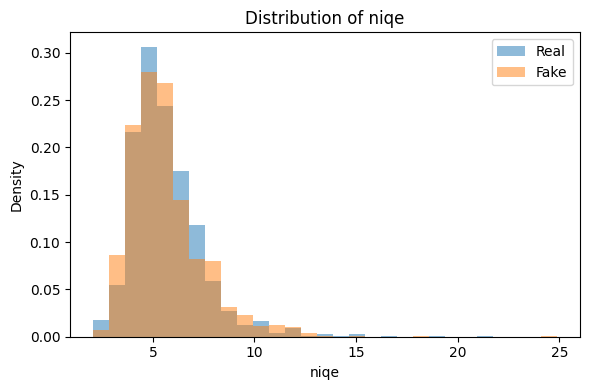


=== Metric: nrqm ===


nrqm - Real:   0%|          | 0/1000 [00:00<?, ?it/s]

nrqm - Fake:   0%|          | 0/1000 [00:00<?, ?it/s]

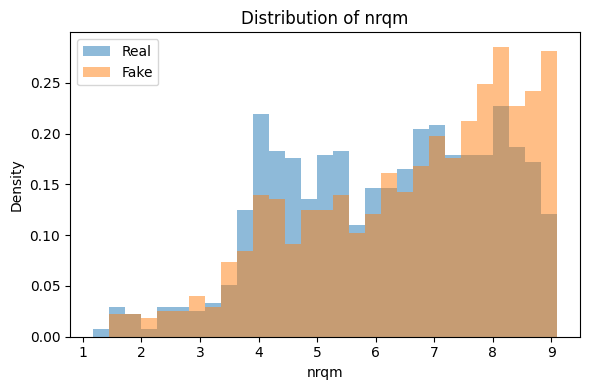


=== Metric: paq2piq ===
Loading pretrained model PAQ2PIQ from /root/.cache/torch/hub/pyiqa/P2P_RoIPoolModel-fit.10.bs.120-ca69882e.pth


paq2piq - Real:   0%|          | 0/1000 [00:00<?, ?it/s]

paq2piq - Fake:   0%|          | 0/1000 [00:00<?, ?it/s]

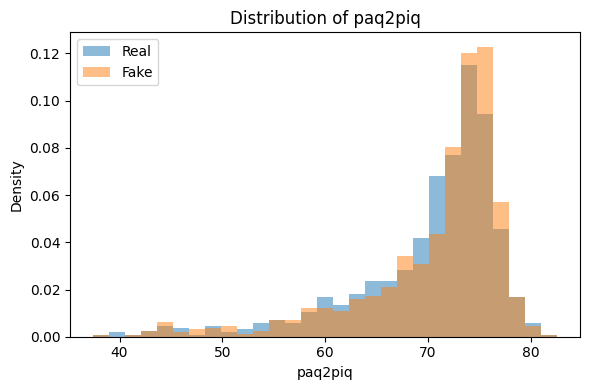


=== Metric: pi ===


pi - Real:   0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
import os
import glob
import random

import numpy as np
import torch
import pyiqa
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# ----------------------------
# Config
# ----------------------------
ROOT_DIR = "Dataset"          # root of your dataset
SPLITS = ["Train", "Validation", "Test"]
LABELS = ["Real", "Fake"]

MAX_IMAGES_PER_CLASS = 1000    # <-- change this to process more/less images
recommended_iqa_methods_no_text = [
    # 'arniqa',
    # 'brisque',
    # 'dbcnn',
    # 'hyperiqa',
    # 'ilniqe',
    # 'laion_aes',
    'musiq',
    'nima',
    'niqe',
    'nrqm',
    'paq2piq',
    'pi',
    'piqe',
    'sfid',
    'topiq_iaa',
    'topiq_iaa_res50',
    'topiq_nr',
    'tres',
    'tres-flive',
    'unique',
    'uranker',
    'wadiqam_nr',
]


# ----------------------------
# Collect image paths
# ----------------------------
image_paths = {label: [] for label in LABELS}

for split in SPLITS:
    for label in LABELS:
        folder = os.path.join(ROOT_DIR, split, label)
        if not os.path.isdir(folder):
            continue

        paths = sorted(glob.glob(os.path.join(folder, "*.jpg")))
        image_paths[label].extend(paths)

# Sample up to MAX_IMAGES_PER_CLASS per class
rng = random.Random(0)  # for reproducibility
sampled_paths = {}

for label in LABELS:
    paths = image_paths[label]
    if not paths:
        print(f"[WARN] No images found for label '{label}'.")
        sampled_paths[label] = []
        continue

    if len(paths) > MAX_IMAGES_PER_CLASS:
        sampled_paths[label] = rng.sample(paths, MAX_IMAGES_PER_CLASS)
    else:
        sampled_paths[label] = paths

    print(f"{label}: using {len(sampled_paths[label])} images")


# ----------------------------
# Prepare pyiqa metrics
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Try to get only NR (no-reference) metrics if the arg exists.
try:
    metric_names = pyiqa.list_models(metric_mode="NR")
except TypeError:
    # Older versions may not support metric_mode, fall back to all models.
    metric_names = pyiqa.list_models()

# Use your recommended subset
metric_names = recommended_iqa_methods_no_text
print("\nCandidate metrics from pyiqa:")
print(metric_names)

scores = {}  # scores[metric_name]['Real'/'Fake'] = list of floats

# ----------------------------
# Run metrics AND plot per metric
# ----------------------------
for metric_name in metric_names:
    # Skip metrics if we have no data at all
    if not sampled_paths["Real"] and not sampled_paths["Fake"]:
        print("[ERROR] No images at all; check ROOT_DIR/SPLITS/LABELS.")
        break

    print(f"\n=== Metric: {metric_name} ===")
    try:
        metric = pyiqa.create_metric(metric_name, device=device)
    except Exception as e:
        print(f"  [SKIP] Could not create metric '{metric_name}': {e}")
        continue

    scores[metric_name] = {label: [] for label in LABELS}

    # Quick smoke test to see if this metric supports single-image input
    try:
        test_label = "Real" if sampled_paths["Real"] else "Fake"
        if sampled_paths[test_label]:
            _ = metric(sampled_paths[test_label][0])
    except Exception as e:
        print(f"  [SKIP] Metric '{metric_name}' does not support single-image inference: {e}")
        del scores[metric_name]
        continue

    # Actually score all images for this metric
    for label in LABELS:
        if not sampled_paths[label]:
            continue

        for img_path in tqdm(sampled_paths[label],
                             desc=f"{metric_name} - {label}",
                             leave=False):
            try:
                val = metric(img_path)

                # Convert result to a Python float
                if torch.is_tensor(val):
                    val = float(val.mean().item())
                else:
                    val = float(val)

                scores[metric_name][label].append(val)

            except Exception as e:
                print(f"    [WARN] Error for metric '{metric_name}' on {img_path}: {e}")

    # ----------------------------
    # Plot histogram for THIS metric now
    # ----------------------------
    real_vals = np.array(scores[metric_name]["Real"], dtype=float)
    fake_vals = np.array(scores[metric_name]["Fake"], dtype=float)

    if real_vals.size == 0 or fake_vals.size == 0:
        print(f"[SKIP PLOT] {metric_name}: missing data for Real or Fake.")
        continue

    vmin = min(real_vals.min(), fake_vals.min())
    vmax = max(real_vals.max(), fake_vals.max())

    if vmin == vmax:
        print(f"[SKIP PLOT] {metric_name}: constant value across samples.")
        continue

    bins = np.linspace(vmin, vmax, 30)

    plt.figure(figsize=(6, 4))
    plt.hist(real_vals, bins=bins, alpha=0.5, label="Real", density=True)
    plt.hist(fake_vals, bins=bins, alpha=0.5, label="Fake", density=True)
    plt.title(f"Distribution of {metric_name}")
    plt.xlabel(metric_name)
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.close()

# (No separate "Plot histograms" loop at the end anymore)
